# DS-GA 3001.009 Modeling Time Series Data

# Week 9 Gaussian Process

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
import time
np.random.seed(12)

## Part I: Data Generation

Visualizaiton functions

In [2]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "r-", 
                 label="pred mean")
    plt.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    plt.legend()

Various generative functions for GP to approximate.

Here we assume that y = 0 when x = 0.

In [3]:
def linear_func(x):
    return 1.2 * x

def sin_wave(x):
    return np.sin(0.9*x).flatten()

Generate train and test data.

In [4]:
x_min = -10
x_max = 10
n_train = 50
generative_func = sin_wave

# X2: we want x in the range of (x_min, x_max)
all_x = np.arange(x_min, x_max, step=0.1)
# Y2: this is the true values of f(x) for x in (x_min, x_max)
# We are NOT using them to train GP. true_y is only used for evaluation
true_y = generative_func(all_x)
# X1, Y1: suppose that we are randomly given n_train training points
X_train = np.random.uniform(x_min, x_max, n_train)
y_train = generative_func(X_train)

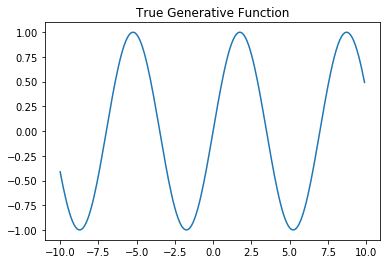

In [5]:
plt.plot(all_x, true_y)
plt.title("True Generative Function")
plt.show()

## Part II GP with sklearn

Sklearn has a very handy API for Gaussian Process regression. 

http://scikit-learn.org/stable/modules/gaussian_process.html

In [6]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel

There are plaenty pre-built kernels defined by the API. Moreover, you can construct you own kernels by combining the pre-built ones.

In [7]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [8]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

The fit() method also automatically selects the hyper-parameters.

In [9]:
gp.kernel_

0.00316**2 + Matern(length_scale=4.69, nu=1.5) + WhiteKernel(noise_level=1e-05)

The predict method returns both mean and std.

In [10]:
mus, sigmas = gp.predict(all_x.reshape(-1,1), return_std=True)

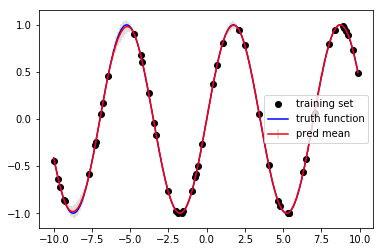

In [11]:
plot_gp(all_x, mus, sigmas, X_train, y_train, true_y=true_y)

## Part III: GP Inference

In this part, please implement the predict_cholesky function.

Sqaured Exponential Kernel:

$$k(x,x') = \sigma^2 exp(-\frac{(x - x')^2}{2 l^2})$$

In [12]:
def exponential_cov(x, y, params):
    """
    Function that implements the squared exponential kernel
    """
    sigma, l = params
    return np.power(sigma,2) * np.exp( -0.5 * np.power(sigma,l) * np.subtract.outer(x, y)**2)

$$ p(y_1|y_2) = N(y | \mu_{y_1|y_2}, \Sigma_{y_1|y_2}) $$

$$\mu_{y_1 | y_2} = BC^{-1}y_2 $$

$$ \Sigma_{y_1 | y_2} = A - BC^{-1}B^T $$

Note that here, we assue zero mean and zero observation noise.



In [13]:
def predict(x_pred, X_train, y_train, kernel, kernel_params, cholesky=True):
    """
    Top level wrapper function for GP prediction
    """
    if cholesky:
        return predict_cholesky(x_pred, X_train, y_train, kernel, kernel_params)
    else:
        return predict_inverse(x_pred, X_train, y_train, kernel, kernel_params)

def predict_inverse(x_pred, X_train, y_train, kernel, kernel_params):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    C: K(X1, X1), a n*n numpy matrix; pass in the value to save computation
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    C = kernel(X_train, X_train, kernel_params)
    B = kernel(x_pred, X_train, kernel_params)
    C_inv = np.linalg.inv(C)
    A = kernel(x_pred, x_pred, kernel_params)
    mu = np.dot(B, C_inv).dot(y_train)
    cov = A - np.dot(B, C_inv).dot(B.T)    
    return mu, cov

def predict_cholesky(x_pred, X_train, y_train, kernel, kernel_params):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    C: K(X1, X1), a n*n numpy matrix; pass in the value to save computation
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    #TODO: please implement this function 
    # compute the mean
    # C = L L^T
    # L^{-1} B^T
    # L^{-1} y_train
    # mu = (L^{-1} B^T)^T (L^{-1} y_train)
    # sigma = A - (L^{-1} B^T)^T (L^{-1} B^T)
    return None, None

kernel_parameters = [2, 0.5]


Prior distribution

$$ y \sim N( \mu_0, \sigma_0^2) $$

Since we assume a zero mean function, we have $\mu_0 = E[y]=0$. Moreover, before looking at the training data, we only know that $y=0$ must lie in the domain of $y$. Therefore, we can set our initial guess for $\sigma_0^2 = k(0,0)$.

rmse = 0.7216677922512522


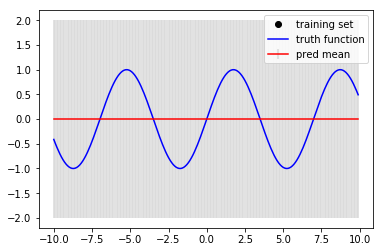

In [14]:
mu_0 = np.zeros(len(all_x))
sigma_0 = np.sqrt(exponential_cov(0, 0, kernel_parameters))
plot_gp(all_x, mu_0, sigma_0, [], [], true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mu_0, true_y))))

Posterior Distribution - single points

Now we start by feeding our GP with a single datum.

rmse = 0.7214718001459153


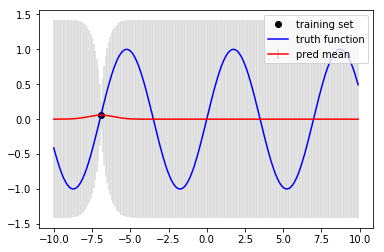

In [15]:
training_data_num = 1
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=True)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

With 10 points

rmse = 0.41830727234190135


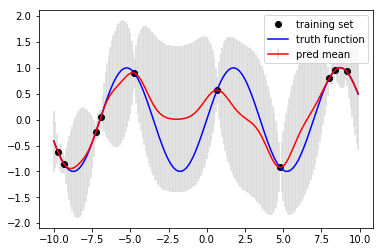

In [16]:
training_data_num = 10
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=True)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

With 20 points

rmse = 0.22601789319585397


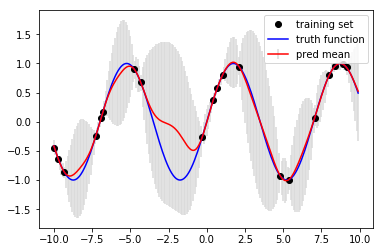

In [17]:
training_data_num = 20
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=True)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

50 points

The warning is caused by some very small negative number that's so close to 0.

rmse = 0.00017622511150997857


/Users/Melancardie/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


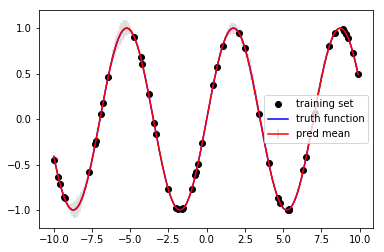

In [18]:
training_data_num = 50
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
mus, cov = predict(all_x, need_X_train, need_y_train, exponential_cov, kernel_parameters, cholesky=True)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format( np.sqrt(mean_squared_error(mus, true_y))))

## Part III: Sampling

For this part, please implement the sample_cholesky function.

In [26]:
def sample_cholesky(mu, cov, n_points, n_samples):
    """
    Function that performs sampling from multi-variate Gaussian using Cholesky Decomposition
    @param mu: a numpy array of size n
    @param cov: a numpy matrix of size n*n
    @param n_points: how many points per sample
    @param n_samples: how many samples
    @return a numpy matrix with dimension (n_points, n_samples)
    """
    # TODO: please implement this function
    return None

Sample from prior

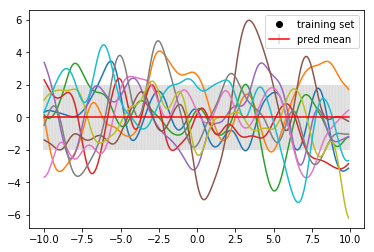

In [32]:
training_data_num = 0
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=False)
sigmas = np.sqrt(np.diag(cov))
# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)
# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

Sample from posterior with 10 points

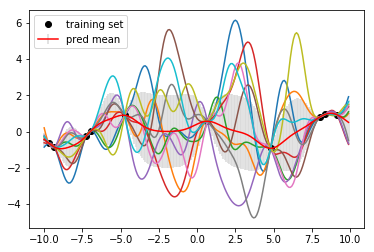

In [33]:
training_data_num = 10
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=False)
sigmas = np.sqrt(np.diag(cov))
# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)
# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

Sample from posterior with 30 points

Since we don't have optmization steps that ensures the numerical statbility. With more points, the resulting $\Sigma_{y_1 | y_2}$ is more likely not to be positive definite due to numerical issues.

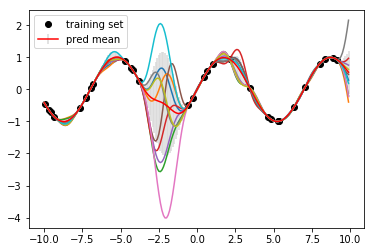

In [34]:
training_data_num = 30
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=False)
sigmas = np.sqrt(np.diag(cov))
# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)
# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)